In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision
import mine_torch

In [2]:
print(torch.cuda.is_available())

True


In [3]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),#6个输出通道32*32
    #32-5+1=28
    nn.AvgPool2d(kernel_size=2, stride=2),#和核的大小一样
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))
device = torch.device('cuda')


X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [4]:

batch_size=100
trans = torchvision.transforms.ToTensor()
mnist_train = torchvision.datasets.MNIST(
    root="./data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.MNIST(
    root="./data", train=False, transform=trans, download=True)

batch_size=100
(train_x,train_y)=mine_torch.batch_data(mnist_train,batch_size,device)
(test_x,test_y)=mine_torch.batch_data(mnist_test,batch_size,device)

test_x.device

device(type='cuda', index=0)

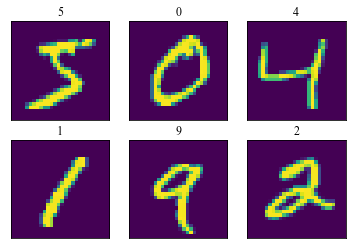

In [5]:
# text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
#                    'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
text_labels =range(10)
fig,axes=plt.subplots(2,3)
axes=axes.flatten()#一维
for i in range(6):
    ax=axes[i]
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow(train_x[0][i][0].cpu())
    ax.set_title(text_labels[train_y[0][i].cpu()])
plt.show()#必须放在cpu上

In [6]:
def calc_acc(X,y,net):
    tot=0
    res=net(X)
    for i in range(X.shape[0]):
        if(res[i].argmax().item()==y[i].item()):
            tot+=1
    return tot/X.shape[0]

In [7]:
lr=1
epoch=60
net.to(device)
net.apply(mine_torch.init_auto)
optimizer=torch.optim.SGD(net.parameters(),lr)
loss=nn.CrossEntropyLoss()

loss_arr,acc_arr=[],[]
net.train()#启用 BatchNormalization 和 Dropout
for i in range(epoch):
    for j in range(batch_size):
        optimizer.zero_grad()
        y_hat=net(train_x[j])
        l=loss(y_hat,train_y[j])
        l.backward()
        optimizer.step()
    if(i%2==0):
        cur_acc=calc_acc(train_x.reshape((-1,1,28,28)),train_y.reshape(-1,1),net)
        print(f'loss= {l:.3f} accuracy={cur_acc:.3f}')        
        loss_arr.append(l)
        acc_arr.append(cur_acc)

loss= 2.302 accuracy=0.099
loss= 2.298 accuracy=0.099
loss= 1.324 accuracy=0.508
loss= 0.304 accuracy=0.888
loss= 0.218 accuracy=0.920
loss= 0.178 accuracy=0.938
loss= 0.153 accuracy=0.951
loss= 0.138 accuracy=0.959
loss= 0.128 accuracy=0.965
loss= 0.121 accuracy=0.969
loss= 0.114 accuracy=0.972
loss= 0.109 accuracy=0.974
loss= 0.105 accuracy=0.976
loss= 0.101 accuracy=0.977
loss= 0.098 accuracy=0.978
loss= 0.095 accuracy=0.979
loss= 0.092 accuracy=0.980
loss= 0.089 accuracy=0.981
loss= 0.087 accuracy=0.982
loss= 0.084 accuracy=0.983
loss= 0.082 accuracy=0.983
loss= 0.080 accuracy=0.984
loss= 0.078 accuracy=0.985
loss= 0.076 accuracy=0.985
loss= 0.074 accuracy=0.986
loss= 0.072 accuracy=0.986
loss= 0.070 accuracy=0.987
loss= 0.068 accuracy=0.987
loss= 0.066 accuracy=0.988
loss= 0.065 accuracy=0.988


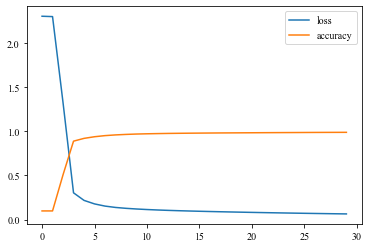

In [8]:
import numpy as np
fig,ax=plt.subplots(1,1)
for i in range(len(loss_arr)):
    if(isinstance(loss_arr[i],np.ndarray)==False):
        loss_arr[i]=loss_arr[i].to(torch.device('cpu')).detach().numpy()

ax.plot(range(len(loss_arr)),loss_arr)
ax.plot(range(len(loss_arr)),acc_arr)
plt.legend(['loss','accuracy'])
plt.show()

In [9]:
calc_acc(test_x.reshape((-1,1,28,28)),test_y.reshape(-1,1),net)

0.9863

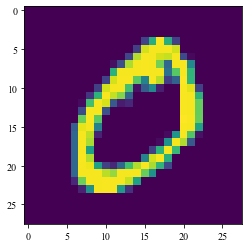

In [10]:
plt.imshow(train_x[0][1][0].cpu())

In [11]:
net(train_x[0][1][0].reshape((-1,1,28,28))).argmax()

tensor(0, device='cuda:0')

In [12]:
torch.save(net.state_dict(), 'data\mnist.params')
